<h1>Fast-DetectGPT: Reproduction des résultats sur les datasets

<h2> 1. Configuration de l'environnement

In [14]:
!pip install torch transformers datasets tqdm numpy matplotlib seaborn scikit-learn --quiet
#!pip install accelerate --quiet

In [3]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
import warnings


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<h2> 2. Téléchargement et préparation des datasets

In [5]:
def download_datasets():
    os.makedirs("datasets", exist_ok=True)

    from datasets import load_dataset

    print("Téléchargement du dataset XSum...")
    xsum = load_dataset("xsum", split="train[:500]")
    xsum_texts = [item["document"] for item in xsum]

    print("Téléchargement du dataset SQuAD...")
    squad = load_dataset("squad", split="train[:500]")
    squad_texts = [item["context"] for item in squad]

    print("Téléchargement du dataset WritingPrompts...")
    writing_prompts_texts = []

    print("Téléchargement du dataset PubMedQA...")
    pubmedqa = load_dataset("pubmed_qa", "pqa_labeled", split="train[:500]")
    pubmedqa_texts = [item["question"] for item in pubmedqa]

    datasets = {
        "xsum": xsum_texts,
        "squad": squad_texts,
        "pubmedqa": pubmedqa_texts
    }

    for dataset_name, texts in datasets.items():
        os.makedirs(f"datasets/{dataset_name}", exist_ok=True)

        selected_texts = texts[:150]

        with open(f"datasets/{dataset_name}/human_texts.json", "w") as f:
            json.dump(selected_texts, f)

    print("Tous les datasets ont été téléchargés et préparés.")
    return datasets

In [8]:
def clean_existing_datasets():
    """Nettoie les datasets existants en supprimant les doublons."""
    dataset_dirs = glob.glob("datasets/*")

    for dataset_dir in dataset_dirs:
        dataset_name = os.path.basename(dataset_dir)
        human_texts_path = os.path.join(dataset_dir, "human_texts.json")

        if os.path.exists(human_texts_path):
            with open(human_texts_path, 'r') as f:
                texts = json.load(f)

            # Éliminer les doublons
            unique_texts = list(dict.fromkeys(texts))
            print(f"{dataset_name}: {len(texts)} textes au total, {len(unique_texts)} textes uniques")

            with open(human_texts_path, 'w') as f:
                json.dump(unique_texts, f)

            for model_dir in glob.glob(os.path.join(dataset_dir, "*")):
                if os.path.isdir(model_dir):
                    model_name = os.path.basename(model_dir)
                    generated_path = os.path.join(model_dir, "generated_texts.json")

                    if os.path.exists(generated_path):
                        with open(generated_path, 'r') as f:
                            gen_texts = json.load(f)

                        unique_gen = list(dict.fromkeys(gen_texts))
                        print(f"  {model_name}: {len(gen_texts)} textes générés, {len(unique_gen)} textes uniques")

                        with open(generated_path, 'w') as f:
                            json.dump(unique_gen, f)

    print("Nettoyage des datasets terminé.")

In [9]:
def prepare_model_generations(datasets, model_names=["gpt2", "gpt-neo-2.7B"]):
    """Génère des textes pour chaque dataset avec chaque modèle."""
    for model_name in model_names:
        try:
            model, tokenizer = load_model(model_name)

            for dataset_name, texts in datasets.items():
                print(f"Génération de textes pour {dataset_name} avec {model_name}...")

                with open(f"datasets/{dataset_name}/human_texts.json", "r") as f:
                    human_texts = json.load(f)

                generated_texts = generate_texts(human_texts, model, tokenizer)

                os.makedirs(f"datasets/{dataset_name}/{model_name}", exist_ok=True)
                with open(f"datasets/{dataset_name}/{model_name}/generated_texts.json", "w") as f:
                    json.dump(generated_texts, f)

            del model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Erreur lors du chargement du modèle {model_name}: {e}")
            continue

In [6]:
datasets = download_datasets()

Téléchargement du dataset XSum...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Téléchargement du dataset SQuAD...


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Téléchargement du dataset WritingPrompts...
Téléchargement du dataset PubMedQA...


README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tous les datasets ont été téléchargés et préparés.


In [10]:
clean_existing_datasets()

xsum: 150 textes au total, 150 textes uniques
pubmedqa: 150 textes au total, 150 textes uniques
squad: 150 textes au total, 31 textes uniques
Nettoyage des datasets terminé.


<h2>3. Génération de textes par le modèle GPT2

In [11]:
def load_model(model_name):
    """Charge un modèle et son tokenizer."""
    print(f"Chargement du modèle {model_name}...")

    model_kwargs = {}
    if 'gpt-j' in model_name or 'neox' in model_name:
        model_kwargs.update(dict(torch_dtype=torch.float16))
    if 'gpt-j' in model_name:
        model_kwargs.update(dict(revision='float16'))

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, **model_kwargs)
    model = model.to(device)

    return model, tokenizer

In [12]:
def generate_texts(human_texts, model, tokenizer, prompt_tokens=30, max_length=200):
    generated_texts = []

    for text in tqdm(human_texts, desc="Génération de textes"):
        encoded = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=1024)
        prompt_tokens = min(prompt_tokens, encoded.shape[1])
        prompt = encoded[:, :prompt_tokens].to(device)

        attention_mask = torch.ones_like(prompt)

        # Génération de texte
        with torch.no_grad():
            output = model.generate(
                prompt,
                attention_mask=attention_mask,  # Ajout du masque d'attention
                max_length=max_length,
                do_sample=True,
                top_p=0.95,
                temperature=0.8,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        generated_texts.append(generated_text)

    return generated_texts

In [13]:
prepare_model_generations(datasets, model_names=["gpt2"])

Chargement du modèle gpt2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Génération de textes pour xsum avec gpt2...


Génération de textes: 100%|██████████| 150/150 [04:04<00:00,  1.63s/it]


Génération de textes pour squad avec gpt2...


Génération de textes: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]


Génération de textes pour pubmedqa avec gpt2...


Génération de textes: 100%|██████████| 150/150 [05:06<00:00,  2.05s/it]


<h3> 4. Implémentation de Fast-DetectGPT

In [ ]:
def compute_log_probs(model, tokenizer, text):
    """Calcule les log-probabilités des tokens pour un texte donné."""
    inputs = tokenizer(text, return_tensors="pt").to(device)
    input_ids = inputs.input_ids

    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=input_ids)
        log_probs = -outputs.loss.item() * (input_ids.shape[1] - 1)

    return log_probs

In [ ]:
def sample_from_model(model, tokenizer, text, n_samples=100, temperature=1.0):
    """Génère des échantillons à partir d'un modèle en utilisant le texte comme contexte.
    Utilise un échantillonnage conditionnel indépendant comme décrit dans l'article Fast-DetectGPT."""
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
    input_ids = tokens.input_ids.to(device)
    attention_mask = tokens.attention_mask.to(device)
    samples = []

    # Pour chaque token du texte, nous allons générer un nouvel échantillon
    for position in range(1, min(input_ids.shape[1], 50)):  # Limiter à 50
        with torch.no_grad():
            outputs = model(input_ids=input_ids[:, :position], attention_mask=attention_mask[:, :position])
            logits = outputs.logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)

            sample_count = min(5, n_samples // position)
            for _ in range(sample_count):
                new_token = torch.multinomial(probs, 1).item()

                modified_tokens = input_ids.clone()
                modified_tokens[0, position-1] = new_token

                sample = tokenizer.decode(modified_tokens[0], skip_special_tokens=True)
                samples.append(sample)

    while len(samples) < n_samples:
        with torch.no_grad():
            position = random.randint(1, min(input_ids.shape[1], 30))
            # Obtenir les probabilités à cette position
            outputs = model(input_ids=input_ids[:, :position], attention_mask=attention_mask[:, :position])
            logits = outputs.logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)

            new_token = torch.multinomial(probs, 1).item()
            modified_tokens = input_ids.clone()
            modified_tokens[0, position-1] = new_token

            sample = tokenizer.decode(modified_tokens[0], skip_special_tokens=True)
            samples.append(sample)

    return samples[:n_samples]

In [ ]:
def compute_curvature(model, tokenizer, text, n_samples=100):
    """Calcule la courbure de probabilité conditionnelle normalisée pour un texte,
    suivant exactement l'algorithme 1 de Fast-DetectGPT."""
    encoded = tokenizer.encode(text)
    if len(encoded) > 1000:
        text = tokenizer.decode(encoded[:1000], skip_special_tokens=True)
        print(f"Texte tronqué de {len(encoded)} à 1000 tokens")

    # Étape 1 : Échantillonnage conditionnel
    samples = sample_from_model(model, tokenizer, text, n_samples=n_samples)

    # Étape 2 & 3 : Calcul de la moyenne et variance des log-probabilités des échantillons
    sample_log_probs = []
    for sample in samples:
        try:
            log_prob = compute_log_probs(model, tokenizer, sample)
            sample_log_probs.append(log_prob)
        except Exception as e:
            print(f"Erreur lors du calcul de log-prob pour un échantillon: {e}")
            continue

    if not sample_log_probs:  # Si aucun échantillon n'a fonctionné
        return 0.0

    # Calcul de la moyenne et écart-type
    mu = np.mean(sample_log_probs)
    sigma = np.std(sample_log_probs, ddof=1)

    if sigma == 0:  # Éviter division par zéro
        sigma = 1e-10

    # Étape 4 : Calcul de la log-probabilité
    original_log_prob = compute_log_probs(model, tokenizer, text)

    # Étape 5 : Calcul de la courbure normalisée
    curvature = (original_log_prob - mu) / sigma

    return curvature

In [ ]:
def fast_detectgpt(model_name, datasets_path="datasets", n_samples=100, threshold=0):
    """Exécute Fast-DetectGPT sur les datasets en suivant exactement l'algorithme 1.
    Utilise un nombre d'échantillons plus élevé (100 par défaut) pour de meilleurs résultats."""
    results = {}

    try:
        model, tokenizer = load_model(model_name)

        for dataset_dir in glob.glob(f"{datasets_path}/*"):
            dataset_name = os.path.basename(dataset_dir)
            results[dataset_name] = {"real": [], "generated": [], "predictions": {"real": [], "generated": []}}

            try:
                with open(f"{dataset_dir}/human_texts.json", "r") as f:
                    human_texts = json.load(f)
            except:
                print(f"Aucun texte humain trouvé pour {dataset_name}")
                continue

            try:
                with open(f"{dataset_dir}/{model_name}/generated_texts.json", "r") as f:
                    generated_texts = json.load(f)
            except:
                print(f"Aucun texte généré trouvé pour {dataset_name} avec {model_name}")
                continue

            # Calcul des courbures pour les textes humains
            for text in tqdm(human_texts[:50], desc=f"Calcul des courbures pour les textes humains de {dataset_name}"):
                try:
                    if len(text) > 4000:
                        text = text[:4000]
                    curvature = compute_curvature(model, tokenizer, text, n_samples=n_samples)
                    results[dataset_name]["real"].append(curvature)
                    prediction = curvature > threshold
                    results[dataset_name]["predictions"]["real"].append(int(prediction))
                except Exception as e:
                    print(f"Erreur lors du traitement d'un texte humain de {dataset_name}: {e}")
                    continue

            # Calcul des courbures pour les textes générés
            for text in tqdm(generated_texts[:50], desc=f"Calcul des courbures pour les textes générés de {dataset_name}"):
                try:
                    if len(text) > 4000:
                        text = text[:4000]
                    curvature = compute_curvature(model, tokenizer, text, n_samples=n_samples)
                    results[dataset_name]["generated"].append(curvature)
                    prediction = curvature > threshold
                    results[dataset_name]["predictions"]["generated"].append(int(prediction))
                except Exception as e:
                    print(f"Erreur lors du traitement d'un texte généré de {dataset_name}: {e}")
                    continue

            with open(f"results_{dataset_name}_{model_name}.json", "w") as f:
                json.dump(results[dataset_name], f)

        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Erreur lors de l'exécution de Fast-DetectGPT avec {model_name}: {e}")

    return results

<h2>5. Evaluation des performances

In [ ]:
results_gpt2 = fast_detectgpt("gpt2", datasets_path="datasets", n_samples=500)

Chargement du modèle gpt2...


Calcul des courbures pour les textes humains de xsum: 100%|██████████| 50/50 [08:45<00:00, 10.52s/it]
Calcul des courbures pour les textes générés de xsum: 100%|██████████| 50/50 [07:23<00:00,  8.88s/it]
Calcul des courbures pour les textes humains de pubmedqa: 100%|██████████| 50/50 [07:57<00:00,  9.55s/it]
Calcul des courbures pour les textes générés de pubmedqa: 100%|██████████| 50/50 [07:29<00:00,  8.98s/it]
Calcul des courbures pour les textes humains de squad: 100%|██████████| 31/31 [04:39<00:00,  9.03s/it]
Calcul des courbures pour les textes générés de squad: 100%|██████████| 31/31 [04:39<00:00,  9.03s/it]


Avec toutes les métriques

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

In [ ]:
def evaluate_performance(results):
    """Évalue les performances de Fast-DetectGPT sur les datasets avec des métriques étendues."""
    for dataset_name, dataset_results in results.items():
        real_curvatures = dataset_results["real"]
        generated_curvatures = dataset_results["generated"]

        print(f"\nDataset: {dataset_name}")
        print(f"Textes humains - Courbure moyenne: {np.mean(real_curvatures):.4f}, Écart-type: {np.std(real_curvatures):.4f}")
        print(f"Textes générés - Courbure moyenne: {np.mean(generated_curvatures):.4f}, Écart-type: {np.std(generated_curvatures):.4f}")

        y_true = [0] * len(real_curvatures) + [1] * len(generated_curvatures)
        y_score = real_curvatures + generated_curvatures

        # Calcul du ROC AUC
        roc_auc = roc_auc_score(y_true, y_score)

        # Calcul de la courbe précision-rappel
        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        pr_auc = auc(recall, precision)

        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")

        # Trouver le meilleur seuil (maximise F1-score)
        f1_scores = []
        for threshold in thresholds:
            y_pred = [1 if score > threshold else 0 for score in y_score]
            if sum(y_pred) > 0:
                prec = precision_score(y_true, y_pred)
                rec = recall_score(y_true, y_pred)
                f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
                f1_scores.append((threshold, f1))
            else:
                f1_scores.append((threshold, 0))

        best_threshold, best_f1 = max(f1_scores, key=lambda x: x[1])
        print(f"Meilleur seuil: {best_threshold:.4f} (F1: {best_f1:.4f})")

        # Calculer les métriques à ce seuil
        y_pred = [1 if score > best_threshold else 0 for score in y_score]
        accuracy = accuracy_score(y_true, y_pred)
        precision_at_best = precision_score(y_true, y_pred)
        recall_at_best = recall_score(y_true, y_pred)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision_at_best:.4f}")
        print(f"Recall: {recall_at_best:.4f}")

        # Matrice de confusion
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Humain', 'IA'],
                    yticklabels=['Humain', 'IA'])
        plt.xlabel('Prédit')
        plt.ylabel('Réel')
        plt.title(f'Matrice de confusion pour {dataset_name}')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_{dataset_name}.png")
        plt.show()

        # Visualisation des distributions
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(real_curvatures, kde=True, label="Textes humains", color="blue", alpha=0.6)
        sns.histplot(generated_curvatures, kde=True, label="Textes générés par IA", color="orange", alpha=0.6)
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil optimal: {best_threshold:.2f}')
        plt.title(f"Distribution des courbures pour {dataset_name}")
        plt.xlabel("Courbure")
        plt.ylabel("Fréquence")
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.kdeplot(real_curvatures, label="Textes humains", color="blue")
        sns.kdeplot(generated_curvatures, label="Textes générés par IA", color="orange")
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil optimal: {best_threshold:.2f}')
        plt.title(f"Densité des courbures pour {dataset_name}")
        plt.xlabel("Courbure")
        plt.ylabel("Densité")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"distribution_{dataset_name}.png")
        plt.show()

        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title(f'Courbe ROC pour {dataset_name}')
        plt.legend(loc="lower right")
        plt.savefig(f"roc_{dataset_name}.png")
        plt.show()

        # Courbe Precision-Recall
        plt.figure(figsize=(6, 6))
        plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Courbe Precision-Recall pour {dataset_name}')
        plt.legend(loc="lower left")
        plt.savefig(f"pr_curve_{dataset_name}.png")
        plt.show()

    return None


Dataset: xsum
Textes humains - Courbure moyenne: 1.7646, Écart-type: 0.3174
Textes générés - Courbure moyenne: 2.0405, Écart-type: 0.2709
ROC AUC: 0.7320
PR AUC: 0.7071
Meilleur seuil: 1.7497 (F1: 0.7667)
Accuracy: 0.7200
Precision: 0.6571
Recall: 0.9200


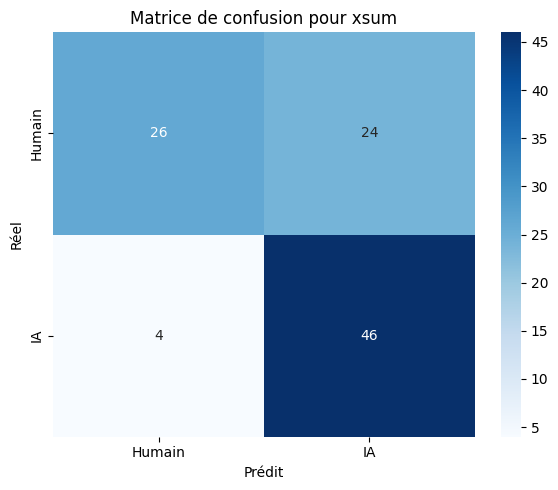

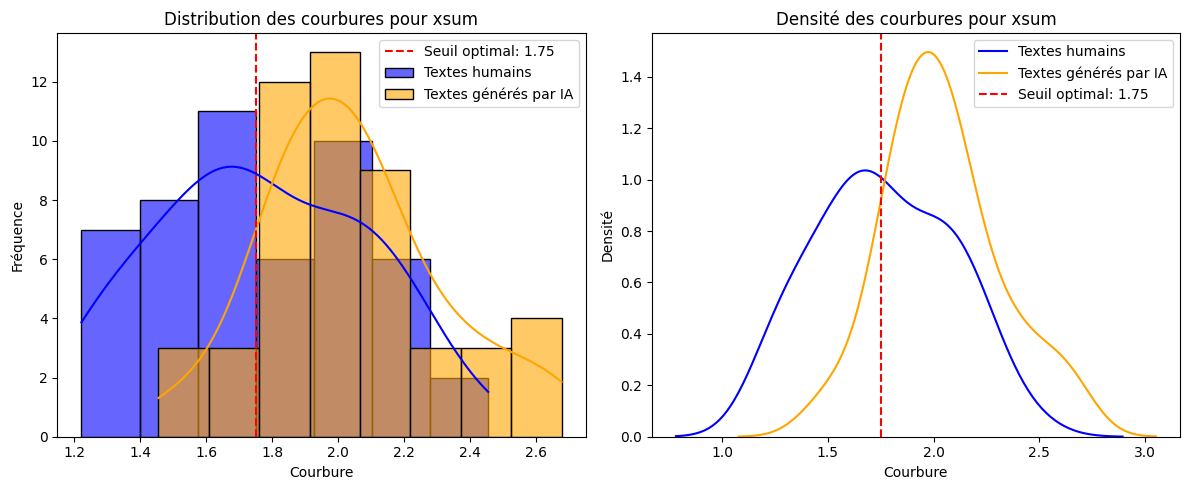

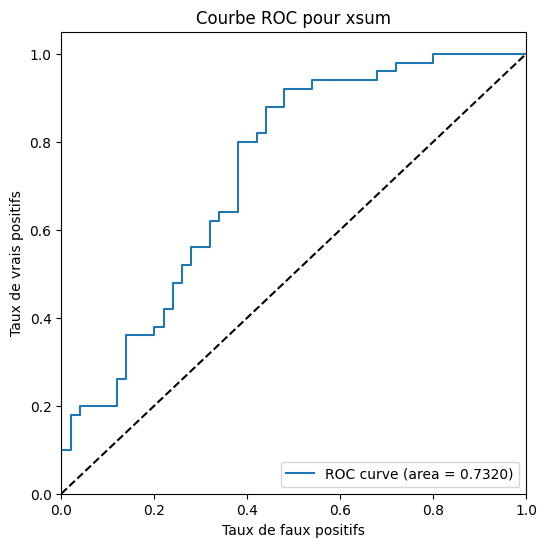

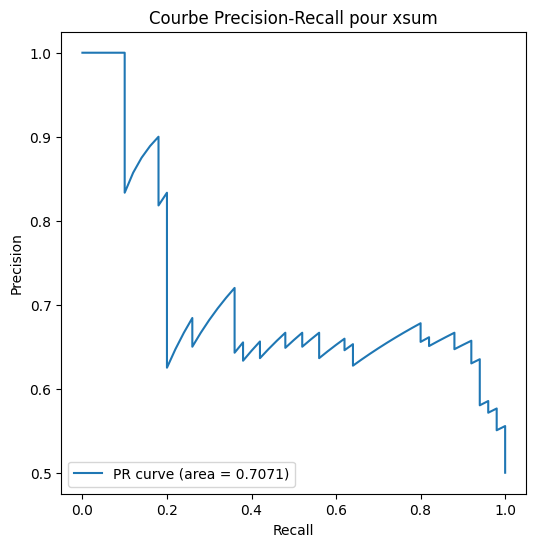


Dataset: pubmedqa
Textes humains - Courbure moyenne: 1.7707, Écart-type: 0.4130
Textes générés - Courbure moyenne: 2.2059, Écart-type: 0.3265
ROC AUC: 0.7916
PR AUC: 0.7474
Meilleur seuil: 1.7911 (F1: 0.7797)
Accuracy: 0.7400
Precision: 0.6765
Recall: 0.9200


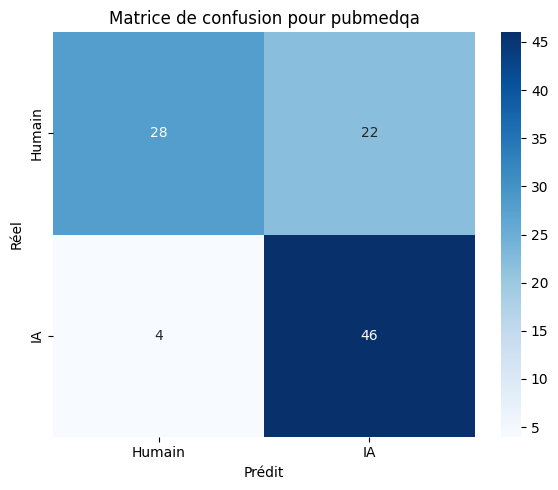

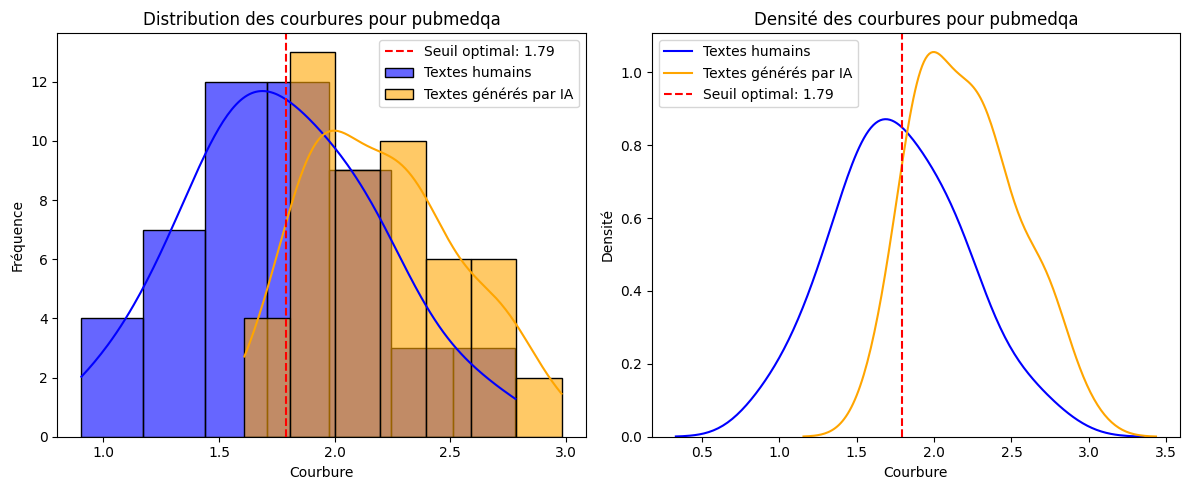

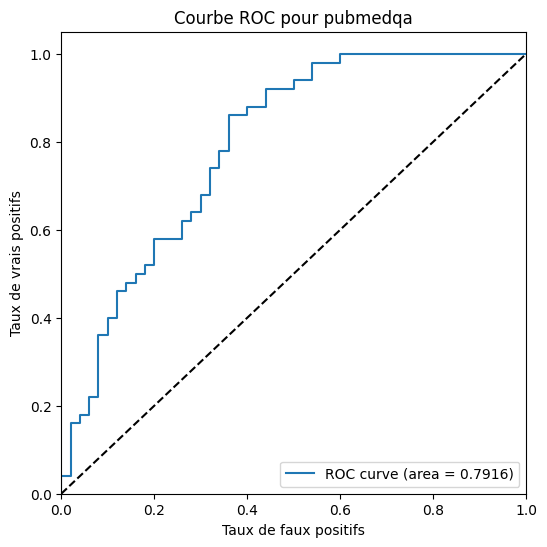

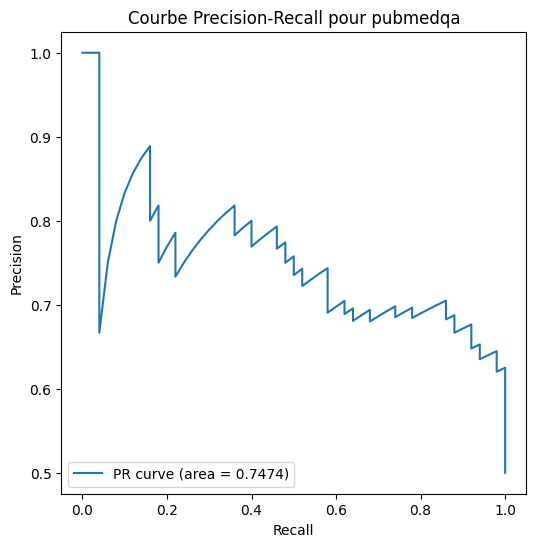


Dataset: squad
Textes humains - Courbure moyenne: 2.2451, Écart-type: 0.2585
Textes générés - Courbure moyenne: 2.3946, Écart-type: 0.3874
ROC AUC: 0.6223
PR AUC: 0.6373
Meilleur seuil: 2.0200 (F1: 0.7073)
Accuracy: 0.6129
Precision: 0.5686
Recall: 0.9355


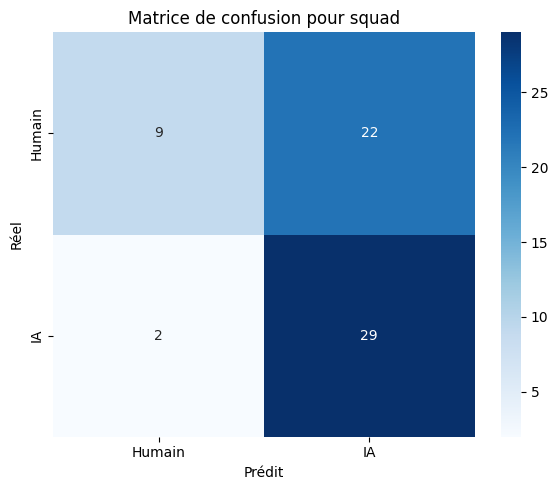

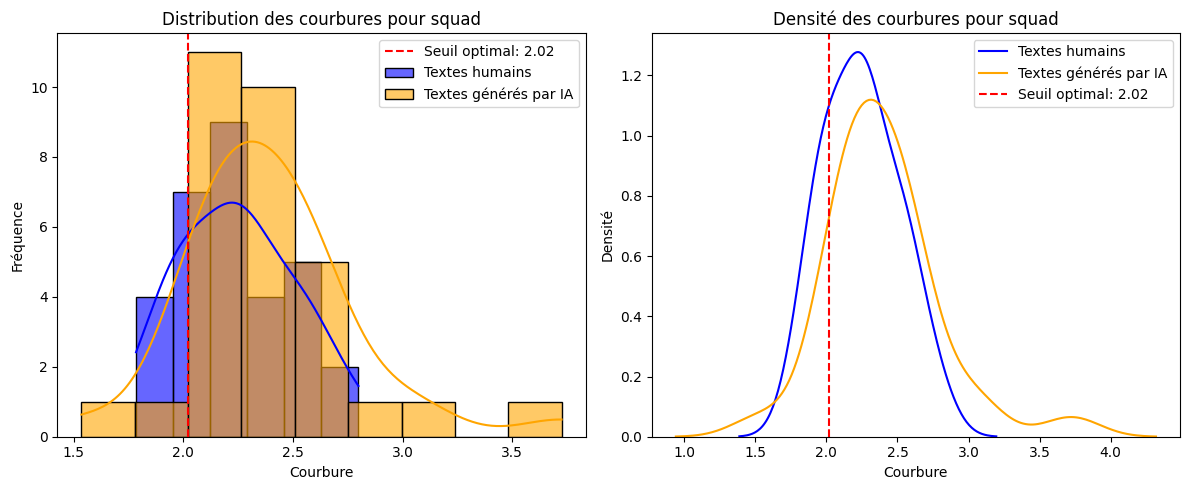

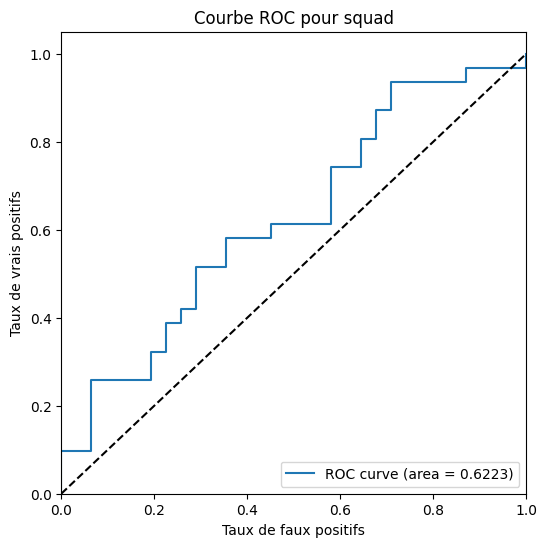

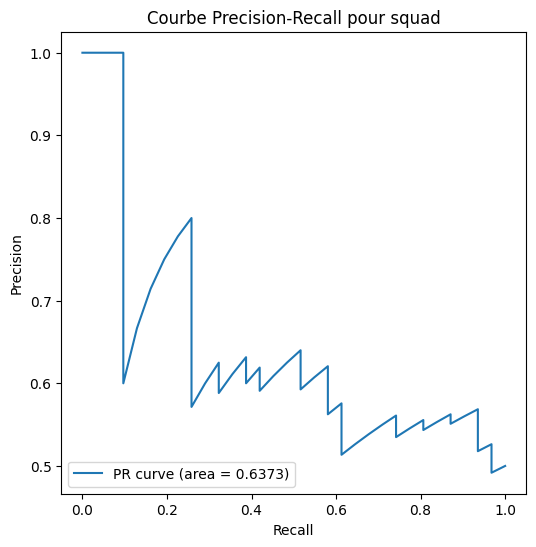

In [ ]:
evaluate_performance(results_gpt2)